None of the existing aerodigestive microbiome papers have particularly useful community composition plots. If I can find a way to visualize the communities, it might be a nice addition to the paper...

Goal is to make abundance barplots with smart coloring (i.e. phyla/orders have the same base color, OTUs within that taxa are shades of the base color. Like my meta-analysis plot and Lawrence's time series plots)

In [3]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [4]:
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.append(src_dir)
import util


In [5]:
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.rel_abun.clean'
fnmeta = '/Users/claire/github/aspiration-analysis/data/clean/rosen.metadata.clean'

meta = pd.read_csv(fnmeta, sep='\t', index_col=0)
df = pd.read_csv(fnotu, sep='\t', index_col=0)
#df.head()
#df.sum(axis=1).sort_values().head()

In [6]:
df = util.collapse_taxonomic_contents_df(df, 'genus', keep_unanno=True)
#df.head()

In [7]:
meta['mbs_consolidated'] = meta['mbs_consolidated'].fillna('nan')
meta['ppi_consolidated'] = meta['ppi_consolidated'].fillna('nan')

patientsamples = meta\
    .groupby(['mbs_consolidated', 'ppi_consolidated', 'site', 'subject_id'])\
    .size()\
    .to_frame('n_samples')\
    .reset_index()

patientsamples.iloc[::65, :]

mbs_consolidated ppi_consolidated           site subject_id  \
0    Aspiration/Penetration      conflicting            bal   13-117-4   
65   Aspiration/Penetration               on            bal   04-157-4   
130                  Normal              off            bal   03-123-6   
195                  Normal               on            bal   04-145-8   
260                  Normal               on    throat_swab   05-171-9   
325                     nan              nan    throat_swab   01-112-7   
390                     nan              off  gastric_fluid   04-080-7   
455                     nan              off    throat_swab   13-106-3   
520                     nan               on          stool   03-105-8   

     n_samples  
0            1  
65           1  
130          1  
195          1  
260          1  
325          1  
390          1  
455          1  
520          1

In [8]:
aero_sites = ['bal', 'gastric_fluid', 'throat_swab']

subjects = patientsamples\
            .query('(site == @aero_sites)')\
            .groupby(['ppi_consolidated', 'mbs_consolidated', 'subject_id'])\
            .size()

# This line shows the number of within-patient comparisons,
# just grouped by MBS status 
print(subjects[subjects == 3].reset_index()
      .groupby(['mbs_consolidated']).size())

## Uncomment this line to see disaggregation by PPI status too
## (this only affects stool_throat comparisons)
#print(subjects[subjects == 2].reset_index()
#      .groupby(['ppi_consolidated', 'mbs_consolidated']).size())        

# And this line is just straight-up the number of unique patients
print(subjects[subjects == 3].reset_index()['subject_id'].unique().shape)
print('')

mbs_consolidated
Aspiration/Penetration    25
Normal                    27
nan                       35
dtype: int64
(87,)



In [9]:
# Keep only subjects iwth all three sites sequenced
subjects = subjects[subjects == 3].reset_index()['subject_id'].unique().tolist()

In [10]:
meta = meta.query('subject_id == @subjects').sort_values(by=['subject_id', 'site'])
meta.shape

(261, 958)

In [11]:
df = df.loc[meta.index]
df.shape

(261, 240)

In [42]:
## Set up colormap for plotting
def get_phylo_colors(otus):
    """
    Return the df with phylum and orders. Make color_dict to plot bar phylogeny.

    Parameters
    ----------
    otus : list or numpy array
        list of OTUs to return colors for. Should be the full taxxonomy
        (starting with k__;...) and in the order that you'll want to plot them.

    Return
    ------
    phylodf : pandas DataFrame
        dataframe with 'phylum', 'class', 'order', etc columns, in the same
        order is in keep_rows. Values are text like ('o__Clostridiales')
    color_dict : dict
        dictionary with {tax_level: RGBA tuple}, where tax_level
        is a string like 'o__Clostridiales'. All phyla and orders
        in keep_rows are in this dict.
    """
    phylodf = pd.DataFrame(otus, columns=['full'])
    phylodf = phylodf['full'].str.split(';', expand=True)
    newcols = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species', 'denovo']
    phylodf.columns = newcols[:len(phylodf.columns)]
    phylodf['otu'] = otus
    
    # If genus is 'g__Other', add the phylum designation
    phylodf['genus'] = phylodf.apply(lambda row: row['phylum'] + ';' + row['genus'] if row['genus'] == 'g__Other'
                                     else row['genus'],
                                     axis=1)
    
    ## Set1 color palette
    colors = sns.color_palette('Set1', 9)
    # red (proteo), blue (bacteroides), green (actino), purple (firmicutes),
    # orange (fuso), yellow, brown (eury), pink (verruco),
    # gray (teneri, cyano, lenti, synerg)
    # this color dict is for 'Set1' color palette
    color_dict = {'p__Acidobacteria': 7,
                  'p__Actinobacteria': 2,
                  'p__Bacteroidetes': 1,
                  'p__Candidatus_Saccharibacteria': 7,
                  'p__Chlamydiae': 7,
                  'p__Cyanobacteria/Chloroplast': 7,
                  'p__Euryarchaeota': 7,
                  'p__Firmicutes': 3,
                  'p__Fusobacteria': 4,
                  'p__Proteobacteria': 0,
                  'p__SR1': 7,
                  'p__Spirochaetes': 7,
                  'p__Tenericutes': 7,
                  'p__Verrucomicrobia': 8,
                  'p__': 7}
    # Convert directly to RGB values
    color_dict = {i: colors[color_dict[i]] for i in color_dict}

    ## Check that all phyla in phylodf have a color
    missingphyla = [i for i in phylodf['phylum'].unique()
                    if i not in color_dict]
    if len(missingphyla) > 0:
        print('You need to give the following phyla colors in get_phylo_colors():')
        print('\n'.join(missingphyla))
        raise ValueError

    for p, subdf in phylodf.groupby('phylum'):
        # Get unique orders in that phylum
        genera = subdf['genus'].unique()
        # Seed a light palette from the top-level phylum color.
        genus_colors = sns.light_palette(color_dict[p], len(genera) + 2)[1:-1]
        # Assign corresponding index in `colors` to each order,
        # and add to the master color_dict
        color_dict.update(
            {genera[i]: genus_colors[i] for i in range(len(genera))})

    return phylodf, color_dict

In [43]:
## Which unique phyla do I have here?
phylodf, color_dict = get_phylo_colors(df.columns)
g = color_dict.keys()[0]
phylodf.query('genus == @g')['otu'].values

array([ 'k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Anaerofilum'], dtype=object)

In [14]:
df = df[phylodf['otu']]

In [15]:
#df.head().plot(kind='bar', stacked=True, colormap='ocean')

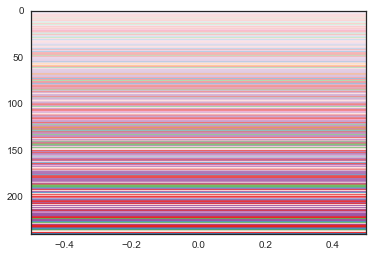

In [16]:
import numpy as np
sns.set_style('white')
phylo_toplot = phylodf['genus'].map(lambda x: color_dict[x])
phylo_toplot = np.array([[i] for i in phylo_toplot.values])
plt.imshow(phylo_toplot, aspect='auto')

In [17]:
## TODO: Figure out how to pass a dictionary of colors into df.plot(kind='bar', stacked=True)
## Also probably will need for color_dict to return otus as keys (instead of genera)

In [18]:
# Sort OTUs by abundance and then re-get color dict
abun_otus = df.mean()
phylodf['abun'] = phylodf['otu'].apply(lambda x: abun_otus[x])
phylodf = phylodf.sort_values(by=['phylum', 'abun'])

In [19]:
_, color_dict = get_phylo_colors(phylodf['otu'].values)

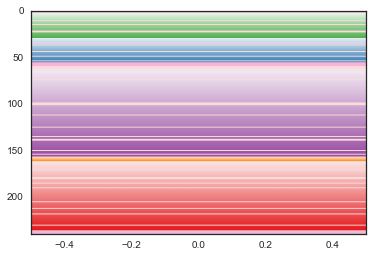

In [20]:
phylo_toplot = phylodf['genus'].map(lambda x: color_dict[x])
phylo_toplot = np.array([[i] for i in phylo_toplot.values])
plt.imshow(phylo_toplot, aspect='auto')

In [21]:
# Reorder dataframe columns to match phylodf
df = df[phylodf['otu']]

In [22]:
# Try plotting with pandas
phylodf['color'] = phylodf['genus'].apply(lambda x: color_dict[x])
#df.head().plot(kind='bar', stacked=True, colors=phylodf['color'])

Almost there! Next, I need to just lump all genera with very low abundances into one "g__Other" so that the dominant genera get to have different colors

In [23]:
abun_thresh = 0.01

def otu2other(row, abun_thresh):
    if not row['otu'].endswith('__') and row['abun'] > abun_thresh:
        return row['otu']
    else:
        return row['otu'].rsplit(';', 1)[0] + ';g__Other'

def genus2other(row, abun_thresh):
    if not row['genus'].endswith('__') and row['abun'] > abun_thresh:
        return row['genus']
    else:
        return row['phylum'] + ';g__Other'

#phylodf['otu2'] = phylodf.apply(lambda row: row['otu'] if row['abun'] > abun_thresh else 
#                                row['otu'].rsplit(';', 1)[0] + ';g__Other', axis=1)
#phylodf['genus2'] = phylodf.apply(lambda row: row['genus'] if row['abun'] > abun_thresh else 
#                                  row['phylum'] + ';g__Other', axis=1)
phylodf['otu2'] = phylodf.apply(lambda row: otu2other(row, abun_thresh), axis=1)
phylodf['genus2'] = phylodf.apply(lambda row: genus2other(row, abun_thresh), axis=1)

In [24]:
_, color_dict = get_phylo_colors(phylodf['otu2'].values)

In [25]:
# Need to switch the abundance ordering so more abundant are on bottom
phylodf = phylodf.sort_values(by=['phylum', 'abun'], ascending=False)
df = df[phylodf['otu']]

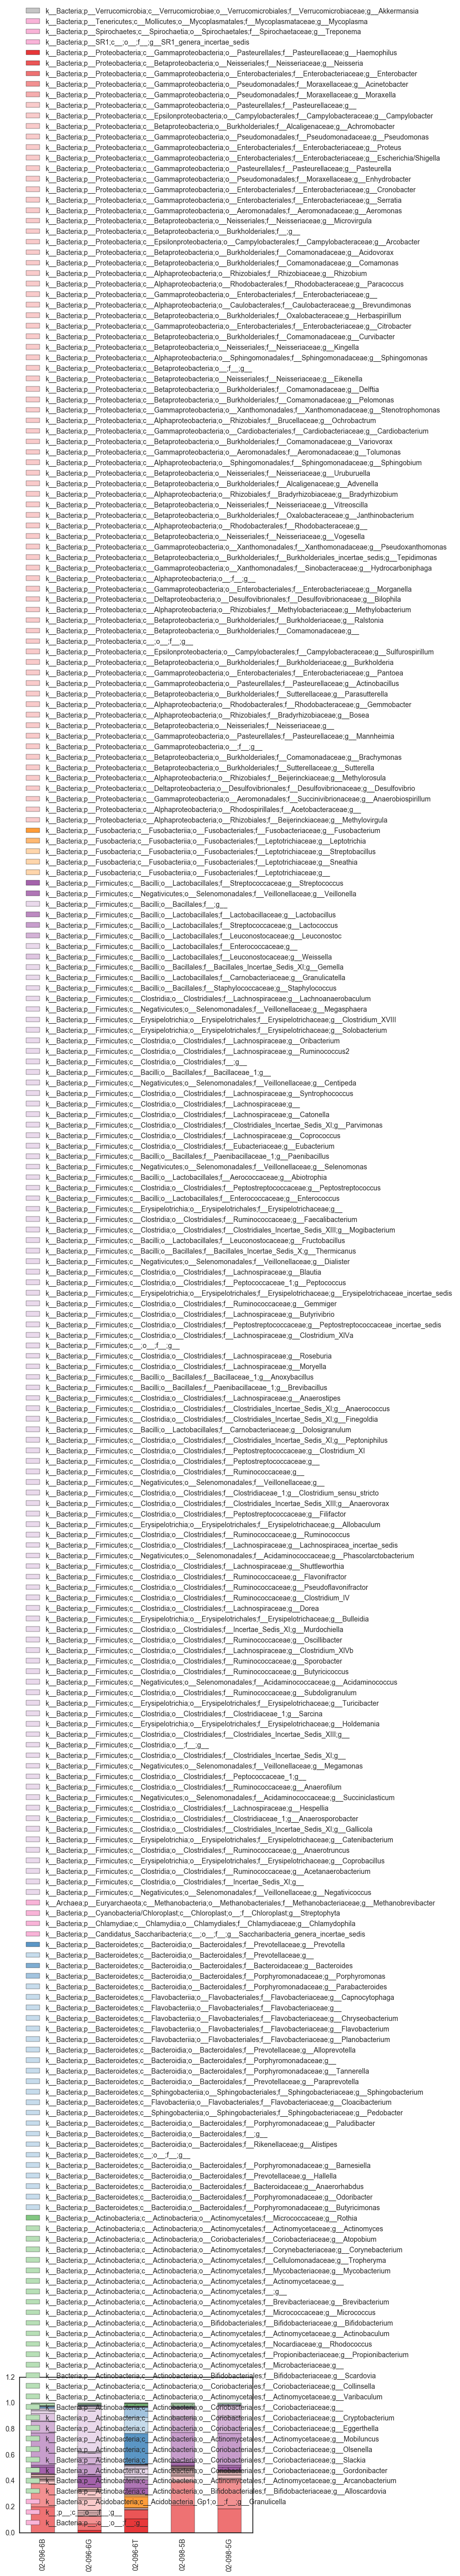

In [482]:
# Now we can plot using pandas
phylodf['color'] = phylodf['genus2'].apply(lambda x: color_dict[x])
df.head().plot(kind='bar', stacked=True, colors=phylodf['color'])

**TODO**: next, we need to:   

1. order samples by descending order of most abundant genus in lung samples,
1. make three separate subplots for hte three sites, with x-axis (patient) ordering the same, and
1. probably make the colors slightly more distinguished so you can identify individual genera?

In [26]:
## Order samples by descending order of most abundant genus in lung samples

# Get mean abundance of each OTU in the lung samples
lung_samples = meta.query('site == "bal"').index
abun_otus = df.loc[lung_samples].median() 

# Set up manual ordering for phyla
phy_order = ['p__Firmicutes',
             'p__Proteobacteria',
             'p__Bacteroidetes',
             'p__Actinobacteria',
             'p__Fusobacteria',
             'p__Cyanobacteria/Chloroplast',
             'p__Verrucomicrobia',
             'p__SR1',
             'p__Spirochaetes',
             'p__Candidatus_Saccharibacteria',
             'p__Tenericutes',
             'p__Chlamydiae',
             'p__Acidobacteria',
             'p__Euryarchaeota']
phylodf['phylum'] = phylodf['phylum'].astype("category")
phylodf['phylum'].cat.set_categories(phy_order, inplace=True)

# Sort OTUs by abundance in the lungs, within each phylum
phylodf['abun'] = phylodf['otu'].apply(lambda x: abun_otus[x])
phylodf = phylodf.sort_values(by=['phylum', 'abun'], ascending=[False, True])

# Get colors for 'otu2', which has 'g__Other' label
_, color_dict = get_phylo_colors(phylodf['otu2'].values)

# Need to reverse the ordering so more abundant are on bottom
phylodf = phylodf.sort_values(by=['phylum', 'abun'], ascending=[True, False])

# Update colors with new ordering
phylodf['color'] = phylodf['genus2'].apply(lambda x: color_dict[x])

# Re-order OTU table columns accordingly
df = df[phylodf['otu']]

# Re-order rows by their abundance in each column
df = df.sort_values(by=df.columns.tolist(), ascending=False)

In [27]:
abun_otus.sort_values(ascending=False).head()

k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus                       0.024077
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacteriales;f__Enterobacteriaceae;g__Enterobacter    0.022987
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus           0.016593
k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae;g__Acinetobacter          0.011097
k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Lactococcus                         0.006707
dtype: float64

In [28]:
#phylodf.groupby('phylum').sum().sort_values(by='abun')

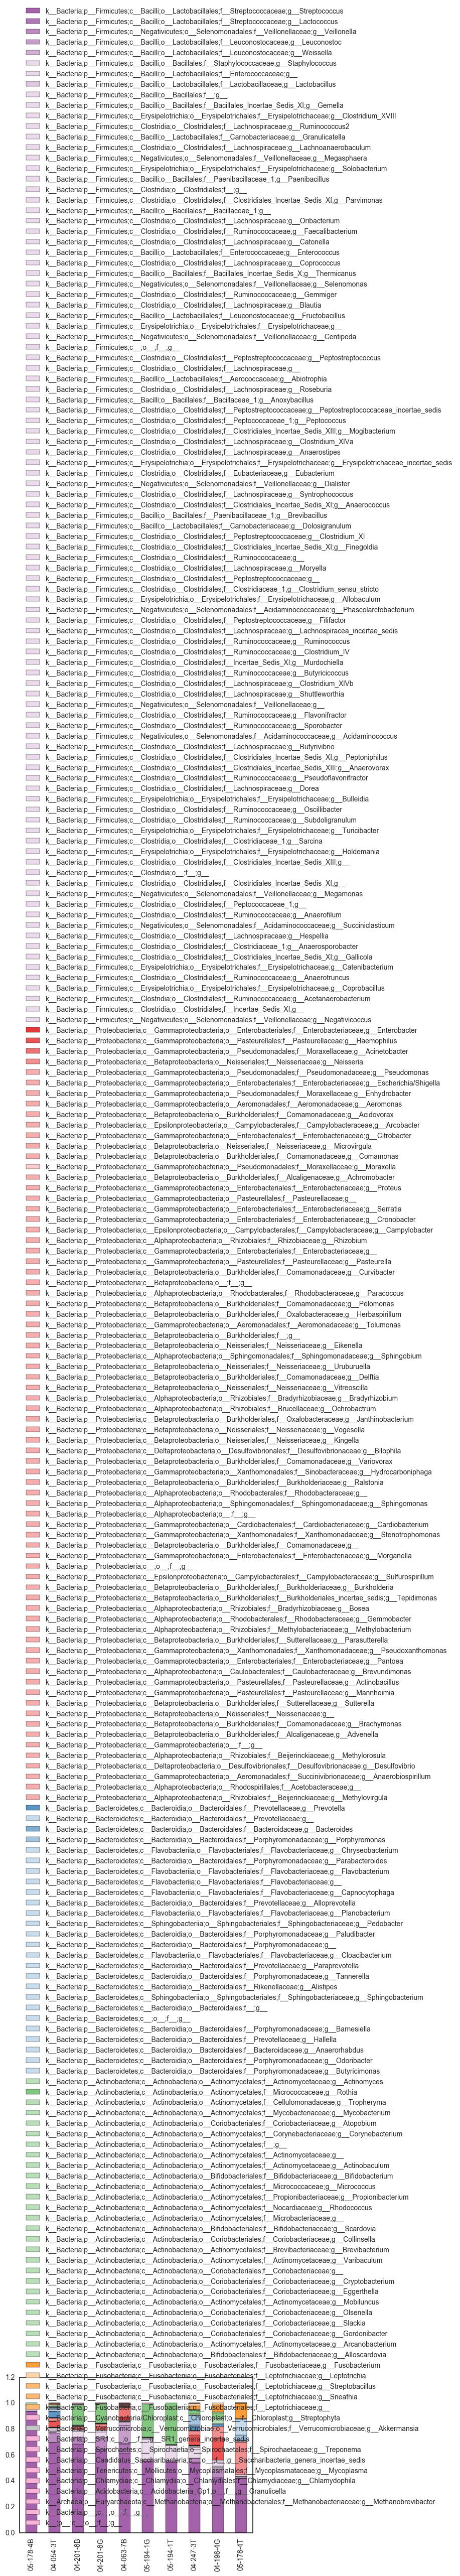

In [494]:
# Plot!
df.head(10).plot(kind='bar', stacked=True, colors=phylodf['color'], legend=True)

In [29]:
## Okay, now that the samples in the dataframe are ordered, I need to:
# 1. grab the lung samples (in the order they're in in the OTU table)
# 2. Get the corresponding patients
# 3. From that, get the corresponding list of gastric and throat samples

lung_samples = df.index.tolist()
lung_samples = [s for s in lung_samples if meta.loc[s, 'site'] == "bal"]

patients = [meta.loc[s, 'subject_id'] for s in lung_samples]

gastric_samples = [meta.query('(subject_id == @s) & (site == "gastric_fluid")').index[0] for s in patients]
throat_samples = [meta.query('(subject_id == @s) & (site == "throat_swab")').index[0] for s in patients]

In [30]:
# Just checking that I did this right and that patients are in the same order
print(' , '.join(patients[0:10]))
print(', '.join(lung_samples[0:10]))
print(', '.join(gastric_samples[0:10]))
print(', '.join(throat_samples[0:10]))

05-178-4 , 04-201-8 , 04-063-7 , 04-247-3 , 04-196-4 , 04-145-8 , 04-136-6 , 02-099-7 , 12-160-1 , 04-287-1
05-178-4B, 04-201-8B, 04-063-7B, 04-247-3B, 04-196-4B, 04-145-8B, 04-136-6B, 02-099-7B, 12-160-1B, 04-287-1B
05-178-4G, 04-201-8G, 04-063-7G, 04-247-3G, 04-196-4G, 04-145-8G, 04-136-6G, 02-099-7G, 12-160-1G, 04-287-1G
05-178-4T, 04-201-8T, 04-063-7T, 04-247-3T, 04-196-4T, 04-145-8T, 04-136-6T, 02-099-7T, 12-160-1T, 04-287-1T


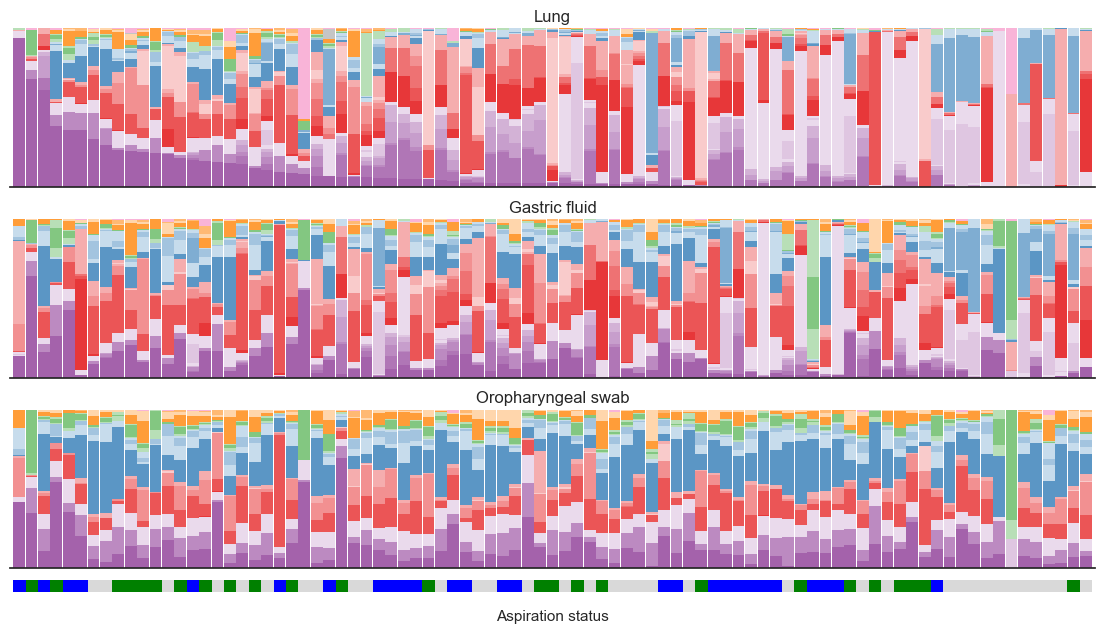

In [546]:
## Stacked bar plot of all three sitse

# Number of patients to plot
N = len(lung_samples)

## Set up grispec
fig = plt.figure(figsize=(14, 6))
# One gridspec on top with 3 subplots (stacked barplots)
gs_plots = gridspec.GridSpec(3, 1, top=0.95, bottom=0.05)
# One on bottom with 1 subplot (aspiration status)
gs_asp = gridspec.GridSpec(1, 1, top=0.03, bottom=0.01)

# Set up the samples I'm going to plot
smpls = {'Lung': lung_samples,
         'Gastric fluid': gastric_samples, 
         'Oropharyngeal swab': throat_samples}
i = 0
for name in ['Lung', 'Gastric fluid', 'Oropharyngeal swab']:
    lst = smpls[name][:N]
    ax = plt.subplot(gs_plots[i])
    # Stacked bar plot from df with samples in rows, OTUs in columns
    df.loc[lst].plot(ax=ax, kind='bar', stacked=True,
                         colors=phylodf['color'], legend=False,
                         width=0.95, edgecolor="none")
    ax.set_ylim([0, 1])
    ax.set_yticklabels('')
    ax.set_xticklabels('')
    sns.despine(ax=ax, left=True)
    ax.set_title(name)
    i += 1

# Add aspiration status on the bottom
ax = plt.subplot(gs_asp[0])

aspdict = {'Normal': '#a65628', 'Aspiration/Penetration': '#f781bf', 'nan': '#999999'}
asplst = [aspdict[i] for i in meta.loc[lst, 'mbs_consolidated']]

aspdf = pd.DataFrame({'color': asplst, 'dummy': [1]*len(asplst)})
aspdf['dummy'].plot(ax=ax, kind='bar', color=aspdf['color'], 
                    width=1.0, edgecolor='none')
# Get rid of all labels
ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_xlabel('Aspiration status')
sns.despine(ax=ax, left=True, bottom=True)

# Investigate predominant taxa

In [39]:
# Add lung_abun, gastric_abun, and throat_abun to phylodf
import copy

sites = ['bal', 'gastric_fluid', 'throat_swab']
abundf = copy.deepcopy(phylodf)
abundf = abundf.drop('abun', axis=1)

for site in sites:
    smpls = meta.query('site == @site').index
    abun_otus = df\
        .loc[smpls]\
        .mean()\
        .to_frame(name=site)

    abundf = pd.merge(abundf, abun_otus, left_on='otu', right_index=True)

abundf = abundf\
    .melt(id_vars=[i for i in abundf.columns if i not in sites],
          var_name='site', value_name='abun')

In [32]:
abundf.groupby(['site', 'phylum']).sum().reset_index().sort_values(by=['site', 'abun'], ascending=False)

top_phyla = ['p__Firmicutes', 'p__Bacteroidetes', 'p__Proteobacteria', 'p__Actinobacteria', 'p__Fusobacteria']
abundf.query('phylum == @top_phyla').groupby(['site', 'phylum']).sum()


abun
site          phylum                     
bal           p__Actinobacteria  0.021048
              p__Bacteroidetes   0.135684
              p__Firmicutes      0.425051
              p__Fusobacteria    0.020081
              p__Proteobacteria  0.382014
gastric_fluid p__Actinobacteria  0.044816
              p__Bacteroidetes   0.214979
              p__Firmicutes      0.314889
              p__Fusobacteria    0.042897
              p__Proteobacteria  0.379073
throat_swab   p__Actinobacteria  0.063522
              p__Bacteroidetes   0.308077
              p__Firmicutes      0.324925
              p__Fusobacteria    0.077092
              p__Proteobacteria  0.224053

In [34]:
# Most abundant genera in each site
abundf\
    .groupby(['site', 'phylum', 'genus'])\
    .sum()\
    .reset_index()\
    .sort_values(by=['site', 'abun'], ascending=False)\
    .groupby('site')\
    .head(10)\

site             phylum             genus      abun
458    throat_swab   p__Bacteroidetes     g__Prevotella  0.209821
540    throat_swab      p__Firmicutes  g__Streptococcus  0.134396
581    throat_swab  p__Proteobacteria    g__Haemophilus  0.118392
546    throat_swab      p__Firmicutes    g__Veillonella  0.092832
593    throat_swab  p__Proteobacteria      g__Neisseria  0.078413
439    throat_swab   p__Bacteroidetes               g__  0.056628
549    throat_swab    p__Fusobacteria  g__Fusobacterium  0.049376
434    throat_swab  p__Actinobacteria         g__Rothia  0.045183
457    throat_swab   p__Bacteroidetes  g__Porphyromonas  0.032740
465    throat_swab      p__Firmicutes               g__  0.024303
374  gastric_fluid  p__Proteobacteria    g__Haemophilus  0.159690
333  gastric_fluid      p__Firmicutes  g__Streptococcus  0.098924
251  gastric_fluid   p__Bacteroidetes     g__Prevotella  0.090278
386  gastric_fluid  p__Proteobacteria      g__Neisseria  0.069198
258  gastric_fluid      p__Firmicutes               g__  0.061457
232  gastric_fluid   p__Bacteroidetes               g__  0.051774
371  gastric_fluid  p__Proteobacteria   g__Enterobacter  0.043901
236  gastric_fluid   p__Bacteroidetes    g__Bacteroides  0.035564
339  gastric_fluid      p__Firmicutes    g__Veillonella  0.033696
305  gastric_fluid      p__Firmicutes  g__Lactobacillus  0.030039
51             bal      p__Firmicutes               g__  0.104778
126            bal      p__Firmicutes  g__Streptococcus  0.088094
167            bal  p__Proteobacteria    g__Haemophilus  0.082188
164            bal  p__Proteobacteria   g__Enterobacter  0.077462
177            bal  p__Proteobacteria      g__Moraxella  0.062843
29             bal   p__Bacteroidetes    g__Bacteroides  0.062572
142            bal  p__Proteobacteria  g__Acinetobacter  0.053256
98             bal      p__Firmicutes  g__Lactobacillus  0.052921
99             bal      p__Firmicutes    g__Lactococcus  0.052172
44             bal   p__Bacteroidetes     g__Prevotella  0.037000

In [69]:
# Most abundant OTUs in each site
fnotu = '/Users/claire/github/aspiration-analysis/data/clean/rosen.otu_table.rel_abun.clean'

meta = pd.read_csv(fnmeta, sep='\t', index_col=0)
rawdf = pd.read_csv(fnotu, sep='\t', index_col=0)

# Keep only subjects iwth all three sites sequenced
aero_sites = ['bal', 'gastric_fluid', 'throat_swab']

subjects = patientsamples\
            .query('(site == @aero_sites)')\
            .groupby(['ppi_consolidated', 'mbs_consolidated', 'subject_id'])\
            .size()
subjects = subjects[subjects == 3].reset_index()['subject_id'].unique().tolist()
meta = meta.query('subject_id == @subjects').sort_values(by=['subject_id', 'site'])
rawdf = rawdf.loc[meta.index]

# Split up OTUs into taxonomic levels
phylodfraw, _  = get_phylo_colors(rawdf.columns)

sites = ['bal', 'gastric_fluid', 'throat_swab']
abundf = copy.deepcopy(phylodfraw)
#abundf.head()

kingdom             phylum              class               order  \
0  k__Bacteria      p__Firmicutes   c__Negativicutes  o__Selenomonadales   
1  k__Bacteria      p__Firmicutes      c__Clostridia    o__Clostridiales   
2  k__Bacteria      p__Firmicutes      c__Clostridia    o__Clostridiales   
3  k__Bacteria  p__Actinobacteria  c__Actinobacteria  o__Actinomycetales   
4  k__Bacteria      p__Firmicutes      c__Clostridia    o__Clostridiales   

                                 family                     genus species  \
0                 f__Acidaminococcaceae  g__Phascolarctobacterium     s__   
1  f__Clostridiales_Incertae_Sedis_XIII            g__Anaerovorax     s__   
2                    f__Lachnospiraceae          g__Ruminococcus2     s__   
3                   f__Actinomycetaceae            g__Actinomyces     s__   
4                    f__Ruminococcaceae                       g__     s__   

          denovo                                                otu  
0    d__denovo58  k__Bacteria;p__Firmicutes;c__Negativicutes;o__...  
1  d__denovo1106  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  
2    d__denovo57  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  
3   d__denovo886  k__Bacteria;p__Actinobacteria;c__Actinobacteri...  
4   d__denovo887  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...

In [70]:
# Get mean abundance of each OTU in each site
for site in sites:
    smpls = meta.query('site == @site').index
    abun_otus = rawdf\
        .loc[smpls]\
        .median()\
        .to_frame(name=site)

    abundf = pd.merge(abundf, abun_otus, left_on='otu', right_index=True)

# Melt to get site/abundance in tidy var/value format
abundf = abundf\
    .melt(id_vars=[i for i in abundf.columns if i not in sites],
          var_name='site', value_name='abun')
#abundf.head()

kingdom             phylum              class               order  \
0  k__Bacteria      p__Firmicutes   c__Negativicutes  o__Selenomonadales   
1  k__Bacteria      p__Firmicutes      c__Clostridia    o__Clostridiales   
2  k__Bacteria      p__Firmicutes      c__Clostridia    o__Clostridiales   
3  k__Bacteria  p__Actinobacteria  c__Actinobacteria  o__Actinomycetales   
4  k__Bacteria      p__Firmicutes      c__Clostridia    o__Clostridiales   

                                 family                     genus species  \
0                 f__Acidaminococcaceae  g__Phascolarctobacterium     s__   
1  f__Clostridiales_Incertae_Sedis_XIII            g__Anaerovorax     s__   
2                    f__Lachnospiraceae          g__Ruminococcus2     s__   
3                   f__Actinomycetaceae            g__Actinomyces     s__   
4                    f__Ruminococcaceae                       g__     s__   

          denovo                                                otu site  abun  
0    d__denovo58  k__Bacteria;p__Firmicutes;c__Negativicutes;o__...  bal   0.0  
1  d__denovo1106  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  bal   0.0  
2    d__denovo57  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  bal   0.0  
3   d__denovo886  k__Bacteria;p__Actinobacteria;c__Actinobacteri...  bal   0.0  
4   d__denovo887  k__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...  bal   0.0

In [71]:
abundf\
    .groupby(['site', 'genus', 'otu'])\
    .sum()\
    .reset_index()\
    .sort_values(by=['site', 'abun'], ascending=False)\
    .groupby('site')\
    .head(10)

site              genus  \
4388    throat_swab      g__Prevotella   
4054    throat_swab     g__Haemophilus   
4590    throat_swab   g__Streptococcus   
4719    throat_swab     g__Veillonella   
4222    throat_swab       g__Neisseria   
3196    throat_swab                g__   
3968    throat_swab   g__Fusobacterium   
4321    throat_swab   g__Porphyromonas   
4377    throat_swab      g__Prevotella   
4497    throat_swab          g__Rothia   
3012  gastric_fluid   g__Streptococcus   
2476  gastric_fluid     g__Haemophilus   
2483  gastric_fluid     g__Haemophilus   
2644  gastric_fluid       g__Neisseria   
2810  gastric_fluid      g__Prevotella   
1618  gastric_fluid                g__   
3141  gastric_fluid     g__Veillonella   
2404  gastric_fluid         g__Gemella   
2743  gastric_fluid   g__Porphyromonas   
2390  gastric_fluid   g__Fusobacterium   
704             bal    g__Enterobacter   
1434            bal   g__Streptococcus   
1004            bal     g__Leuconostoc   
905             bal     g__Haemophilus   
958             bal     g__Lactococcus   
309             bal   g__Acinetobacter   
898             bal     g__Haemophilus   
1577            bal       g__Weissella   
1425            bal  g__Staphylococcus   
955             bal     g__Lactococcus   

                                                    otu      abun  
4388  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...  0.111856  
4054  k__Bacteria;p__Proteobacteria;c__Gammaproteoba...  0.082214  
4590  k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  0.076807  
4719  k__Bacteria;p__Firmicutes;c__Negativicutes;o__...  0.067652  
4222  k__Bacteria;p__Proteobacteria;c__Betaproteobac...  0.053617  
3196  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...  0.036706  
3968  k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...  0.025377  
4321  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...  0.018562  
4377  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...  0.016368  
4497  k__Bacteria;p__Actinobacteria;c__Actinobacteri...  0.014314  
3012  k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  0.053283  
2476  k__Bacteria;p__Proteobacteria;c__Gammaproteoba...  0.048966  
2483  k__Bacteria;p__Proteobacteria;c__Gammaproteoba...  0.040088  
2644  k__Bacteria;p__Proteobacteria;c__Betaproteobac...  0.032066  
2810  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...  0.019023  
1618  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...  0.012130  
3141  k__Bacteria;p__Firmicutes;c__Negativicutes;o__...  0.008391  
2404  k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...  0.007055  
2743  k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...  0.006761  
2390  k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o...  0.005733  
704   k__Bacteria;p__Proteobacteria;c__Gammaproteoba...  0.022987  
1434  k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  0.010318  
1004  k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  0.005371  
905   k__Bacteria;p__Proteobacteria;c__Gammaproteoba...  0.004897  
958   k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  0.004130  
309   k__Bacteria;p__Proteobacteria;c__Gammaproteoba...  0.003926  
898   k__Bacteria;p__Proteobacteria;c__Gammaproteoba...  0.002924  
1577  k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  0.002580  
1425  k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacill...  0.002515  
955   k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...  0.002501

Papers say:

Pseudomonas, Streptococcus, Prevotella, Fusobacteria, and Veillonella predominate, with lesser contributions   from   potential   pathogens,   including Haemophilus and Neisseria [Beck]

Most bacteria identified in the lung were also in the mouth, but specific bacteria   such   as   Enterobacteriaceae,  Haemophilus,   Methylobacterium, and Ralstonia species were disproportionally represented in the lungs compared with values predicted by the neutral model.

